In [1]:
import logging
import numpy as np
import pandas as pd
import yaafelib
import librosa
import aubio
from aubio import onset
from appconfig import setup_logging
from scipy.io import wavfile
import matplotlib.pyplot as plt

%matplotlib inline  

In [106]:
featurespecs = \
    ['LSF: LSF blockSize={} stepSize={}',
     'SpectralDecrease: SpectralDecrease blockSize={} stepSize={}',
     'SpectralFlatnessPerBand: SpectralFlatnessPerBand blockSize={} stepSize={}',
     'SpectralFlux: SpectralFlux blockSize={} stepSize={}',
     'SpectralSlope: SpectralSlope blockSize={} stepSize={}',
     'SpectralRolloff: SpectralRolloff blockSize={} stepSize={}',
     'MFCC: MFCC blockSize={} stepSize={}']

    
path = '/home/tracek/Data/gender/test/ablackball-20121113-vvk/wav/a0333.wav'
path = '/home/tracek/Data/gender/Voxforge/ralfherzog-20070923-en8/flac/en8-013.flac'
female_path = '/home/tracek/Data/gender/test/Darrr-20170412-ong/en-0922.wav'
female_path2 = '/home/tracek/Data/gender/test/jlrice9673-20090623-agu/a0255.wav'
female_path3 = '/home/tracek/Data/gender/test/jlrice9673-20090623-agu/a0254.wav'
male_path = '/home/tracek/Data/gender/test/akiplaner-20100315-tin/b0118.wav'
male_path2 = '/home/tracek/Data/gender/test/ablackball-20121113-vvk/wav/a0333.wav'

find_salient = True
sr = 16000
block_size = 1024
nfft = 512

In [107]:
def get_onsets(signal, sr, nfft, hop, onset_detector_type='hfc', onset_threshold=0.3):
    onsets = []

    onset_detector = aubio.onset(onset_detector_type, nfft, hop, sr)
    onset_detector.set_threshold(onset_threshold)

    signal_windowed = np.array_split(signal, np.arange(hop, len(signal), hop))

    for frame in signal_windowed[:-1]:
        if onset_detector(frame):
            onsets.append(onset_detector.get_last())
    return np.array(onsets[1:])

def get_start_end_samples(y, sr, nfft, hop,  onset_detector_type='hfc', onset_threshold=0.1):
    onsets_fw = get_onsets(y, sr, nfft, hop, onset_detector_type, onset_threshold)
    onsets_bw = get_onsets(y[::-1], sr, nfft, hop, onset_detector_type, onset_threshold)
    onsets_bw_rev = (len(y) - np.array(onsets_bw)[::-1])
    return onsets_fw[0], onsets_bw_rev[-1]


def get_salient_region(y, sr, start, end, start_buffer=0.0, end_buffer=0.0):
    salient_start = max(0, start - int(start_buffer * sr))
    salient_end = min(len(y), end + int(end_buffer * sr))
    return y[salient_start:salient_end]

In [108]:
def plot_feature(feature, y_len):
    x_spacing = np.linspace(0, y_len, len(feature))

    no_figures = feature.shape[1]
    if no_figures == 1:
        plt.figure(figsize=(15,5))
        plt.plot(x_spacing, feature)
    else:
        f, ax = plt.subplots(no_figures, 1, sharex=True, figsize=(15,15))
        for idx in range(no_figures):
            ax[idx].plot(x_spacing, feature[:, idx])
    plt.xlabel('time')

In [109]:
feature_plan = yaafelib.FeaturePlan(sample_rate=sr, normalize=True)
for featurespec in featurespecs:
    feature = featurespec.format(block_size, block_size // 2)
    assert feature_plan.addFeature(feature), 'Failed to load %s feature' % feature
    logging.info('Feature %s loaded', feature)
    
engine = yaafelib.Engine()
engine.load(feature_plan.getDataFlow())
afp = yaafelib.AudioFileProcessor()

In [110]:
y, sr = librosa.load(male_path, sr=sr)
y = librosa.util.normalize(y)
if find_salient:
    y_start, y_end = get_start_end_samples(y.astype('float32'), sr, nfft=nfft, hop=nfft // 2)
    y = get_salient_region(y, sr, start=y_start, end=y_end, start_buffer=0.2, end_buffer=0.4)

In [111]:
feats = engine.processAudio(y.reshape(1, -1))
x_shape_expected = next(iter(feats.values())).shape[0] # random item
for name, feat in feats.items():
    if feat.shape[0] != x_shape_expected:
        print('Feature {} is messed up. Expected {} got {}'.format(name, x_shape_expected, feat.shape[0]))

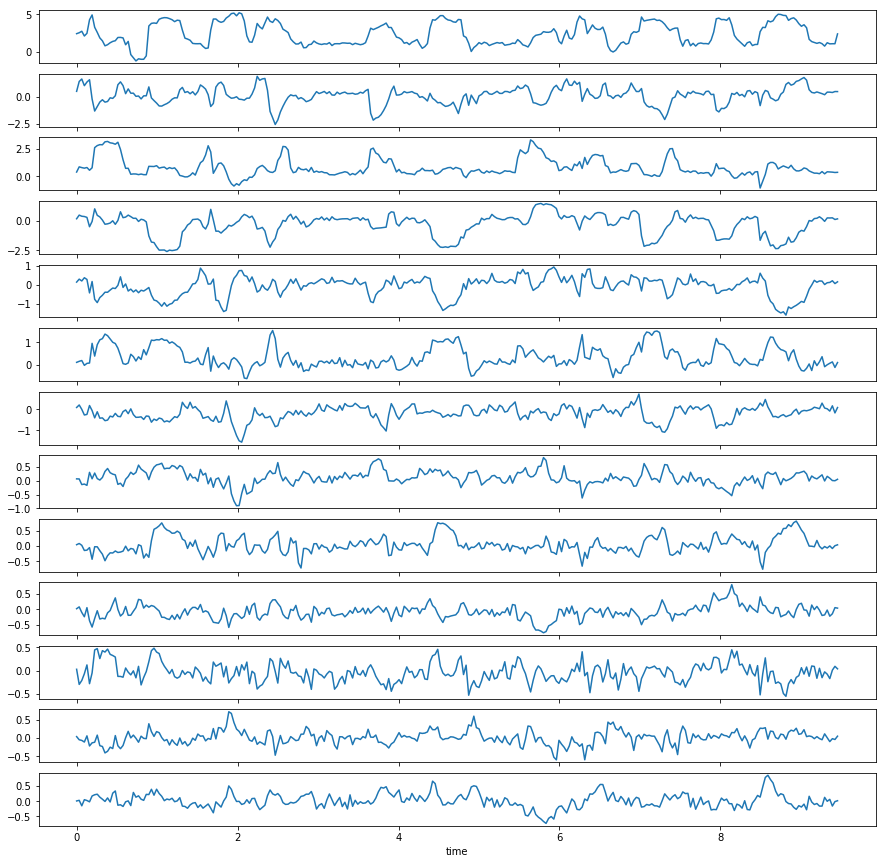

In [112]:
plot_feature(feats['MFCC'], len(y) / sr)

In [113]:
block_size = 1024
hop = block_size // 4
pitch_o = aubio.pitch("yinfft", block_size, hop, sr)
pitch_o.set_unit('Hz')
pitch_o.set_tolerance(0.8)
y_in = y.astype('float32')
y_win = np.array_split(y_in, np.arange(hop, len(y_in), hop))

In [114]:
pitches = []
confidences = []
tolerance = 0.8

for frame in y_win[:-1]:
    pitch = pitch_o(frame)[0]
    confidence = pitch_o.get_confidence()
    if confidence < tolerance:
        pitches.append(pitch)
    confidences.append(confidence)
    
pitches = np.array(pitches)

In [115]:
pitches_peaks = pitches[pitches > 2000]

In [116]:
pitches_peaks.mean()

3427.8855

In [117]:
pitches.std()

928.64819

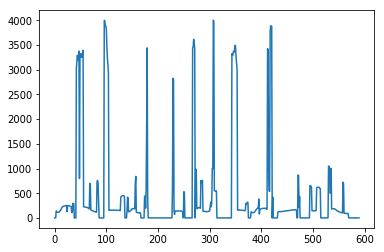

In [118]:
plt.plot(pitches)

In [119]:
pitches

array([    0.        ,     0.        ,     0.        ,   141.73735046,
         127.77017975,   121.76503754,   114.83977509,   113.46708679,
         113.93525696,   122.31440735,   135.18493652,   149.19898987,
         169.98780823,   186.06260681,   203.33314514,   223.52857971,
         228.14836121,   235.85317993,   239.80172729,   242.83149719,
         244.77529907,   246.15774536,   247.9848938 ,   250.32943726,
         125.95195007,   251.11553955,   248.44137573,   246.06318665,
         245.11288452,   242.79632568,   239.1784668 ,   235.7429657 ,
         221.79394531,   110.61898804,   110.19612885,   294.86291504,
         285.02664185,   289.8989563 ,     0.        ,     0.        ,
           0.        ,     0.        ,  3041.66650391,  3168.08520508,
        3291.046875  ,  3192.89526367,  3200.23071289,  3376.69238281,
         798.08001709,  3289.82592773,  3322.34472656,  3323.06054688,
        3247.76757812,  3271.46704102,  3336.96948242,  3393.61523438,
      